# Tutorial for `MDRefine` - 1b

In these notebooks we are going to perform several different refinements of MD-generated trajectories by employing the package `MDRefine`. In this way, we believe the usage of `MDRefine` will become clear and easy to emulate for your own case of interest. Input data for these examples may be downloaded from Zenodo as indicated in `load_data_oligomers.ipynb`.

We remind you to have a look at our paper https://arxiv.org/pdf/2411.07798 and at the documentation https://www.bussilab.org/doc-MDRefine/MDRefine/index.html.

Required assistance may be opened at https://github.com/bussilab/MDRefine/issues.

In [1]:
import numpy as np
import jax.numpy as jnp
import pandas
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
# import from parent directory
import sys
sys.path.append('../')

In [3]:
from MDRefine import load_data, minimizer, split_dataset, hyper_minimizer, MDRefinement, unwrap_dict

## 2. Force-field refinement

In this section, we are going to reproduce part of the results presented in *I. Gilardoni et al., "Boosting ensemble refinement with transferable force-field corrections: synergistic optimization for molecular simulations", J. Phys. Chem. Letters 15.5 (2024)* https://pubs.acs.org/doi/full/10.1021/acs.jpclett.3c03423.

In particular, we will focus on fitting a force-field correction to refine structural ensembles of RNA oligomers.

### a. Load data

Load experimental data, observables and forward model as previously done. Also, load force-field correction terms and corresponding functional form.

In [4]:
infos = {}

# Define global properties, valid for all the systems:
infos['global'] = {
    'path_directory': '../../DATA',
    'system_names': ['AAAA','CCCC','GACC','UUUU','UCAAUC'],

    # Then, define properties which are specific of each system, like experimental data and observables
    # If some properties are the same for all the systems, you can store them just once in infos['global']
    'g_exp': ['backbone1_gamma_3J', 'backbone2_beta_epsilon_3J', 'sugar_3J', 'NOEs', ('uNOEs','<')],
    'forward_qs': ['backbone1_gamma','backbone2_beta_epsilon','sugar'],
    'obs': ['NOEs','uNOEs'],
    'forward_coeffs': 'original_fm_coeffs'}

# Select the stride for the frames
stride = 1000

In [5]:
def forward_model_fun(fm_coeffs, forward_qs, selected_obs=None):

    # 1. compute the cosine (which is the quantity you need in the forward model;
    # you could do this just once before loading data)
    forward_qs_cos = {}

    for type_name in forward_qs.keys():
        forward_qs_cos[type_name] = np.cos(forward_qs[type_name])

    # if you have selected_obs, compute only the corresponding observables
    if selected_obs is not None:
        for type_name in forward_qs.keys():
            forward_qs_cos[type_name] = forward_qs_cos[type_name][:,selected_obs[type_name+'_3J']]

    # 2. compute observables (forward_qs_out) through forward model
    forward_qs_out = {
        'backbone1_gamma_3J': fm_coeffs[0]*forward_qs_cos['backbone1_gamma']**2 + fm_coeffs[1]*forward_qs_cos['backbone1_gamma'] + fm_coeffs[2],
        'backbone2_beta_epsilon_3J': fm_coeffs[3]*forward_qs_cos['backbone2_beta_epsilon']**2 + fm_coeffs[4]*forward_qs_cos['backbone2_beta_epsilon'] + fm_coeffs[5],
        'sugar_3J': fm_coeffs[6]*forward_qs_cos['sugar']**2 + fm_coeffs[7]*forward_qs_cos['sugar'] + fm_coeffs[8] }

    return forward_qs_out

In [6]:
infos['global']['forward_model'] = forward_model_fun

Now, let's define the force-field correction terms: we selected (for each molecule)
\begin{equation}
\beta\Delta V = \sum_{i}\Bigl[\phi_1\cos\alpha_i + \phi_2\sin\alpha_i + \phi_3 \cos \zeta_i + \phi_4 \sin\zeta_i\Bigr]
\end{equation}
where the sum is over the residues. We can also consider this correction on $\alpha$ dihedral angles only (choose among the following two notebook cells).

Since Numpy arrays `ff_terms` have columns

`['sinalpha[0]', 'sinalpha[1]', 'sinalpha[2]', 'sinzeta[0]', 'sinzeta[1]', 'sinzeta[2]', 'cosalpha[0]', 'cosalpha[1]', 'cosalpha[2]', 'coszeta[0]', 'coszeta[1]', 'coszeta[2]']`,

these two corrections are defined by the following functions (use `jax.numpy`).

In [7]:
# correction on alpha dihedral angles only
def ff_correction_tetramers(pars, f):
    out = jnp.matmul(pars, (f[:,[0,6]]+f[:,[1,7]]+f[:,[2,8]]).T)
    return out

def ff_correction_hexamers(pars, f):
    out = jnp.matmul(pars, (f[:,[0,10]]+f[:,[1,11]]+f[:,[2,12]]+f[:,[3,13]]+f[:,[4,14]]).T)
    return out

infos['global']['ff_correction'] = ff_correction_tetramers
infos['UCAAUC'] = {'ff_correction': ff_correction_hexamers}

infos['global']['names_ff_pars'] = ['sin alpha', 'cos alpha']

In [8]:
# correction on alpha, zeta dihedral angles
def ff_correction_tetramers(pars, f):
    out = jnp.matmul(pars, (f[:,[0,6,3,9]]+f[:,[1,7,4,10]]+f[:,[2,8,5,11]]).T)
    return out

def ff_correction_hexamers(pars, f):
    out = jnp.matmul(pars, (f[:,[0,10,5,15]]+f[:,[1,11,6,16]]+f[:,[2,12,7,17]]+f[:,[3,13,8,18]]+f[:,[4,14,9,19]]).T)
    return out

infos['global']['ff_correction'] = ff_correction_tetramers
infos['UCAAUC'] = {'ff_correction': ff_correction_hexamers}

infos['global']['names_ff_pars'] = ['sin alpha', 'cos alpha', 'sin zeta', 'cos zeta']

In [9]:
# split frames based on "demuxing" (continuous trajectories from temperature replica exchange)
for name_sys in ['AAAA', 'CCCC', 'GACC', 'UUUU']:  # except hexamers
    infos[name_sys] = {'n_temp_replica': 6}

In [10]:
data = load_data(infos, stride=stride)

loading data from directory...
loading  AAAA
loading  CCCC
loading  GACC
loading  UUUU
loading  UCAAUC
done


Now, let's define the **regularization** for the force-field refinement. You can choose among `plain l2` (acting on the coefficients) or `KL divergence` (acting directly on the ensemble).

In [11]:
regularization = {'force_field_reg': 'KL divergence'}

### b. Minimize the loss function and analyse the results
for a single choice of the hyper-parameter $\beta$

Use function `minimizer` with selected data, regularization and beta as input

In [12]:
Result = minimizer(data, regularization=regularization, beta=100)

New evaluation:
loss:  26712.192935201077
gradient:  [-42027.37177324  -7424.74335444 -20567.55001088  11752.99709332] 

New evaluation:
loss:  20083.376406234107
gradient:  [ -9396.56938882 -14445.16542491   7191.87802912  -2812.81920524] 

New evaluation:
loss:  13717.574573764286
gradient:  [ -756.54884242 -1760.25707842  4562.80909375 -1000.83872418] 

New evaluation:
loss:  13532.769189473689
gradient:  [ 238.57586882 -124.18492875   -6.57754762  -18.56805486] 

New evaluation:
loss:  326483.92558518983
gradient:  [-88624.88517682  32105.12727824 -79933.39228963   5655.52661116] 

New evaluation:
loss:  13532.675328738285
gradient:  [ 239.02849238 -123.9199797    -6.25435466  -18.3537759 ] 

New evaluation:
loss:  13532.58073472669
gradient:  [ 239.48098295 -123.65284393   -5.93266688  -18.13904182] 

New evaluation:
loss:  76576.3895459867
gradient:  [-249081.01148316   78924.93797219 -213238.82153446    4616.65877608] 

New evaluation:
loss:  13508.647971398688
gradient:  [-193.

In [13]:
vars(Result).keys()

dict_keys(['loss', 'pars', 'mini', 'intermediates', 'time', 'reg_ff', 'av_g', 'chi2', 'weights_new', 'logZ_new'])

Besides the same quantities already described in the previous notebook `Tutorial_1.ipynb` (such as: **av_g**, **chi2**, **weights_new**, **logZ_new**), we now have:
- optimal force-field correction parameters **pars**;
- output of minimization **mini**;
- value of force-field regularization **reg_ff**.

In [14]:
Result.pars

array([ 1.12436584,  0.89356142, -0.3770965 , -1.0470043 ])

In [15]:
Result.mini

      fun: 6723.204303268038
 hess_inv: array([[ 4.50223174e-04,  1.82306316e-04, -3.09037582e-04,
         2.96897551e-04],
       [ 1.82306316e-04,  1.04189672e-03, -2.48601678e-05,
         1.63958082e-05],
       [-3.09037582e-04, -2.48601678e-05,  2.77189415e-04,
        -3.26280813e-04],
       [ 2.96897551e-04,  1.63958082e-05, -3.26280813e-04,
         5.68968936e-04]])
      jac: array([-6.33549288e-05,  2.24225295e-06, -8.12841195e-05, -1.94177722e-05])
  message: 'Optimization terminated successfully.'
     nfev: 48
      nit: 25
     njev: 48
   status: 0
  success: True
        x: array([ 1.12436584,  0.89356142, -0.3770965 , -1.0470043 ])

In [16]:
Result.reg_ff

{'AAAA': DeviceArray(0.54335402, dtype=float64),
 'CCCC': DeviceArray(0.47897542, dtype=float64),
 'GACC': DeviceArray(0.26820783, dtype=float64),
 'UUUU': DeviceArray(0.72890498, dtype=float64),
 'UCAAUC': DeviceArray(1.10532337, dtype=float64)}

### c. Determine optimal hyper parameter $\beta$ through cross validation (scan over $\beta$)

Split the data set with `split_dataset` and minimize the loss function with `minimizer` over different values of the hyperparamter $\beta$ in logarithmic scale.

In [17]:
data_train, data_valid, valid_obs, valid_frames = split_dataset(data, random_state=2, replica_infos=infos)

Input random_state employed both for valid_obs and valid_frames


../MDRefine/loss_and_minimizer.py:1144: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  w = data_mol.weights[valid_frames_mol]


In [18]:
log10_betas = np.arange(-2, 7, 0.5)

Results = {}

for log10_beta in log10_betas:
    print(log10_beta)

    beta = 10**np.float64(log10_beta)
    Results[log10_beta] = minimizer(data_train, regularization=regularization, beta=beta, data_valid=data_valid)

    print(Results[log10_beta].loss)

    clear_output()

In [19]:
# Check the convergence of the minimization
print([Results[log10_beta].mini.success for log10_beta in log10_betas])

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False]


Plot the loss function in training and validation, refined coefficients of the force-field correction, the $\chi^2$ and the regularization as a function of the hyperparameter $\beta$.

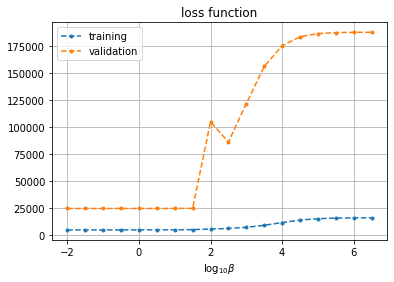

In [20]:
loss = [Results[log10_beta].loss for log10_beta in log10_betas]
loss_valid = [Results[log10_beta].loss_valid for log10_beta in log10_betas]

plt.title('loss function')
plt.plot(log10_betas, loss, '.--', label = 'training')
plt.plot(log10_betas, loss_valid, '.--', label = 'validation')
plt.xlabel(r'$\log_{10}\beta$')
plt.legend()
plt.grid()

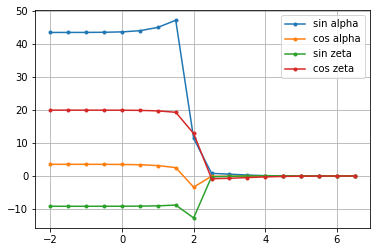

In [21]:
coeffs = np.array([Results[log10_beta].pars for log10_beta in log10_betas]).T

for i in range(len(coeffs)):
    plt.plot(log10_betas, coeffs[i], '.-', label=data.properties.names_ff_pars[i])

plt.legend()
plt.grid()

In [22]:
chi2s = [np.sum(unwrap_dict(Results[log10_beta].chi2)) for log10_beta in log10_betas]
n_obs_train = data_train.properties.tot_n_experiments(data_train)

red_chi2s = np.array(chi2s)/n_obs_train

chi2s_valid1 = [np.sum(unwrap_dict(Results[log10_beta].chi2_valid)) for log10_beta in log10_betas] # .chi2_valid
red_ch2s_valid1 = np.array(chi2s_valid1)/n_obs_train

chi2s_valid2 = [np.sum(unwrap_dict(Results[log10_beta].chi2_new_obs)) for log10_beta in log10_betas] # .chi2_valid
n_obs_valid = len(unwrap_dict(valid_obs))

red_chi2s_valid2 = np.array(chi2s_valid2)/n_obs_valid

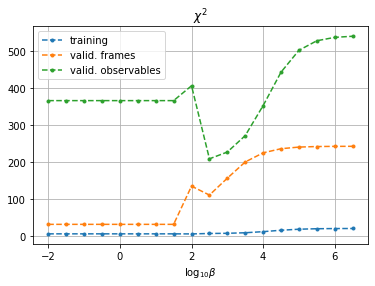

In [23]:
plt.plot(log10_betas, red_chi2s, '.--', label='training')
plt.plot(log10_betas, red_ch2s_valid1, '.--', label='valid. frames')
plt.plot(log10_betas, red_chi2s_valid2, '.--', label='valid. observables')

plt.legend()
plt.title('$\chi^2$')
plt.xlabel(r'$\log_{10}\beta$')
plt.grid()

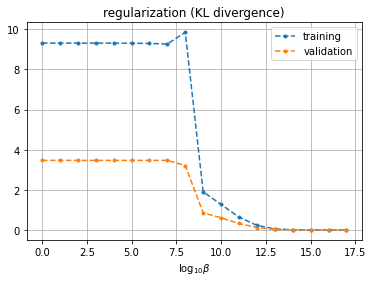

In [24]:
D_KL_train = [np.sum(unwrap_dict(Results[log10_beta].reg_ff)) for log10_beta in log10_betas]
D_KL_valid = [np.sum(unwrap_dict(Results[log10_beta].reg_ff_valid)) for log10_beta in log10_betas]

plt.title('regularization (KL divergence)')
plt.plot(D_KL_train, '.--', label = 'training')
plt.plot(D_KL_valid, '.--', label = 'validation')
plt.xlabel(r'$\log_{10}\beta$')
plt.legend()
plt.grid()

### d. Determine optimal hyper parameter $\beta$ through cross validation (automatic optimization)

Let's use `hyper_minimizer` to get the optimal value of the hyperparameter $\beta$. Here, `random_states` can be either a list of values or an integer; if it is an integer, you will take values in `np.arange(random_states)`.

Let's take the same `random_state` used for the scan, so that we can compare the results of `hyper_minimizer` with the previous plot of the $\chi^2$. 

To validate the efficiency of the convergence, start from a high $\beta$ value.

In [25]:
starting_beta = 1e5

mini = hyper_minimizer(data, regularization=regularization, starting_beta=starting_beta, random_states=[2])

Input random_state employed both for valid_obs and valid_frames


../MDRefine/loss_and_minimizer.py:1144: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  w = data_mol.weights[valid_frames_mol]



log10 hyperpars:  [('beta', 5.0)]
New evaluation:
loss:  15821.079509837204
gradient:  [-44652.52599575  -1203.79504886 -41026.69479807   3444.17760245] 

New evaluation:
loss:  341775.4851971243
gradient:  [128158.35518432  17996.74697861 158434.45639082  13656.06094328] 

New evaluation:
loss:  15457.115160718111
gradient:  [29701.1735501   1229.28196103 26473.2081698  10183.42968344] 

New evaluation:
loss:  15559.230242231008
gradient:  [30665.1823073  -1818.97729355 23137.98231249 -7069.4965171 ] 

New evaluation:
loss:  15296.399688085276
gradient:  [30232.67736023   -82.2074335  25039.41334812  2581.1638408 ] 

New evaluation:
loss:  16733.022775983016
gradient:  [17506.83537889 14046.06088845 36951.43079658  2912.65385047] 

New evaluation:
loss:  15281.719903080188
gradient:  [29168.2083377   1248.27085717 26245.75375737  2610.79377622] 

New evaluation:
loss:  16403.39129493641
gradient:  [ 18752.89339645 -22960.7127745   34410.93178617   4032.56334081] 

New evaluation:
los

../MDRefine/loss_and_minimizer.py:1144: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  w = data_mol.weights[valid_frames_mol]


New evaluation:
loss:  15821.079509837244
gradient:  [-44652.52599575  -1203.79504886 -41026.69479807   3444.17760245] 

New evaluation:
loss:  47911.788083320636
gradient:  [15301.40602407  3337.15569488 20085.21147397   778.13092589] 

New evaluation:
loss:  13016.185280201142
gradient:  [15909.2608497   2789.1360364  17292.72564472  7586.98071059] 

New evaluation:
loss:  15762.327925375175
gradient:  [ 8309.00026822 -6107.55555499  3391.29704104 -9257.27788713] 

New evaluation:
loss:  12110.381665115747
gradient:  [14645.86788754  -790.69727145 13883.57616044  1768.24004668] 

New evaluation:
loss:  18660.509402756612
gradient:  [ -9297.43002413  15238.47415691 -15991.65307809  -4406.97149196] 

New evaluation:
loss:  12076.165337443425
gradient:  [15253.44930309  2289.43941198 13386.87711676  1107.60047579] 

New evaluation:
loss:  12066.610491342171
gradient:  [14322.01192999  2066.54351484 14219.69375805   871.07926237] 

New evaluation:
loss:  12047.438346208251
gradient:  [14

../MDRefine/loss_and_minimizer.py:1144: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  w = data_mol.weights[valid_frames_mol]


New evaluation:
loss:  15821.079509837247
gradient:  [-44652.52599575  -1203.79504886 -41026.69479807   3444.17760245] 

New evaluation:
loss:  15263.53133397703
gradient:  [2762.99897236 1708.47510326 4714.61036371 -652.60709904] 

New evaluation:
loss:  14045.124884223578
gradient:  [4032.99227295 2677.83719294 5520.07743837 -631.04525352] 

New evaluation:
loss:  31913.721687955935
gradient:  [ -95994.15849479 -111190.9995555   -45071.63648614   12878.22156433] 

New evaluation:
loss:  12194.962751664014
gradient:  [5576.19450429 3940.51872933 6303.8056749  -432.48733707] 

New evaluation:
loss:  11313.221109342554
gradient:  [  -16.3373314  -2385.28505808  3016.57920523   344.38921582] 

New evaluation:
loss:  7625.002011435467
gradient:  [ -840.44503031    -3.81658482 -1882.83197804 -1033.07157514] 

New evaluation:
loss:  5387.0033034643375
gradient:  [ -50.34184198   21.19785481 -598.27037463 -327.92398489] 

New evaluation:
loss:  4904.804693636569
gradient:  [-189.43994899    

In [26]:
mini

          fun: DeviceArray(48942.71839454, dtype=float64)
     hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
 intermediate: <MDRefine.hyperminimizer.hyper_minimizer.<locals>.hyper_intermediate_class object at 0x7f6fc86e81d0>
          jac: array([0.00302151])
      message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
         nfev: 3
          nit: 1
         njev: 3
       status: 0
      success: True
            x: array([8.8817842e-16])

The `intermediate` attribute shows the intermediate steps of the hyperminimization (i.e., the minimization of the $\chi^2$ to search for the optimal hyperparameters)

In [27]:
vars(mini.intermediate)

{'av_chi2': DeviceArray([373079.71228769, 348939.36538501,  48942.71839454], dtype=float64),
 'av_gradient': DeviceArray([[7.60761702e+03],
              [5.14439560e+04],
              [3.02150783e-03]], dtype=float64),
 'log10_hyperpars': DeviceArray([[5.0000000e+00],
              [4.0000000e+00],
              [8.8817842e-16]], dtype=float64)}

With the default value `which_set = 'validating'` (namely, minimize the $\chi^2$ on left-out frames but same observables), $\beta$ stops at low values due to the plateau in the figure, and we found $\beta = 1$.

Let's try also with `which_set = 'validation'` (left-out observables).

In [28]:
mini2 = hyper_minimizer(data, regularization=regularization, starting_beta=starting_beta, random_states=[2], which_set='validation')


Input random_state employed both for valid_obs and valid_frames


../MDRefine/loss_and_minimizer.py:1144: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  w = data_mol.weights[valid_frames_mol]



log10 hyperpars:  [('beta', 5.0)]
New evaluation:
loss:  15821.079509837204
gradient:  [-44652.52599575  -1203.79504886 -41026.69479807   3444.17760245] 

New evaluation:
loss:  341775.4851971243
gradient:  [128158.35518432  17996.74697861 158434.45639082  13656.06094328] 

New evaluation:
loss:  15457.115160718111
gradient:  [29701.1735501   1229.28196103 26473.2081698  10183.42968344] 

New evaluation:
loss:  15559.230242231008
gradient:  [30665.1823073  -1818.97729355 23137.98231249 -7069.4965171 ] 

New evaluation:
loss:  15296.399688085276
gradient:  [30232.67736023   -82.2074335  25039.41334812  2581.1638408 ] 

New evaluation:
loss:  16733.022775983016
gradient:  [17506.83537889 14046.06088845 36951.43079658  2912.65385047] 

New evaluation:
loss:  15281.719903080188
gradient:  [29168.2083377   1248.27085717 26245.75375737  2610.79377622] 

New evaluation:
loss:  16403.39129493641
gradient:  [ 18752.89339645 -22960.7127745   34410.93178617   4032.56334081] 

New evaluation:
los

../MDRefine/loss_and_minimizer.py:1144: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  w = data_mol.weights[valid_frames_mol]


New evaluation:
loss:  15821.079509837244
gradient:  [-44652.52599575  -1203.79504886 -41026.69479807   3444.17760245] 

New evaluation:
loss:  47911.788083320636
gradient:  [15301.40602407  3337.15569488 20085.21147397   778.13092589] 

New evaluation:
loss:  13016.185280201142
gradient:  [15909.2608497   2789.1360364  17292.72564472  7586.98071059] 

New evaluation:
loss:  15762.327925375175
gradient:  [ 8309.00026822 -6107.55555499  3391.29704104 -9257.27788713] 

New evaluation:
loss:  12110.381665115747
gradient:  [14645.86788754  -790.69727145 13883.57616044  1768.24004668] 

New evaluation:
loss:  18660.509402756612
gradient:  [ -9297.43002413  15238.47415691 -15991.65307809  -4406.97149196] 

New evaluation:
loss:  12076.165337443425
gradient:  [15253.44930309  2289.43941198 13386.87711676  1107.60047579] 

New evaluation:
loss:  12066.610491342171
gradient:  [14322.01192999  2066.54351484 14219.69375805   871.07926237] 

New evaluation:
loss:  12047.438346208251
gradient:  [14

../MDRefine/loss_and_minimizer.py:1144: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  w = data_mol.weights[valid_frames_mol]


New evaluation:
loss:  15821.079509837247
gradient:  [-44652.52599575  -1203.79504886 -41026.69479807   3444.17760245] 

New evaluation:
loss:  15263.53133397703
gradient:  [2762.99897236 1708.47510326 4714.61036371 -652.60709904] 

New evaluation:
loss:  14045.124884223578
gradient:  [4032.99227295 2677.83719294 5520.07743837 -631.04525352] 

New evaluation:
loss:  31913.721687955935
gradient:  [ -95994.15849479 -111190.9995555   -45071.63648614   12878.22156433] 

New evaluation:
loss:  12194.962751664014
gradient:  [5576.19450429 3940.51872933 6303.8056749  -432.48733707] 

New evaluation:
loss:  11313.221109342554
gradient:  [  -16.3373314  -2385.28505808  3016.57920523   344.38921582] 

New evaluation:
loss:  7625.002011435467
gradient:  [ -840.44503031    -3.81658482 -1882.83197804 -1033.07157514] 

New evaluation:
loss:  5387.0033034643375
gradient:  [ -50.34184198   21.19785481 -598.27037463 -327.92398489] 

New evaluation:
loss:  4904.804693636569
gradient:  [-189.43994899    

In [29]:
mini2

          fun: DeviceArray(48942.71839454, dtype=float64)
     hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
 intermediate: <MDRefine.hyperminimizer.hyper_minimizer.<locals>.hyper_intermediate_class object at 0x7f6fc86e8390>
          jac: array([0.00302151])
      message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
         nfev: 3
          nit: 1
         njev: 3
       status: 0
      success: True
            x: array([8.8817842e-16])

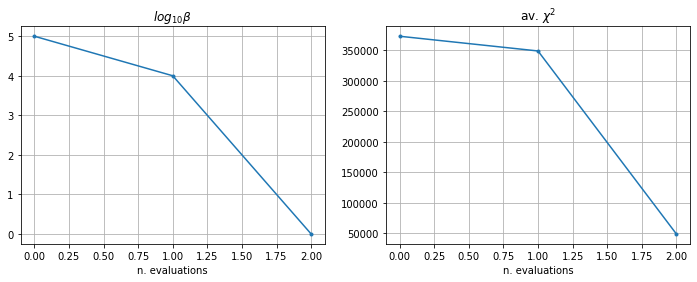

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(mini2.intermediate.log10_hyperpars, '.-')
axs[0].set_title(r'$log_{10} \beta$')
axs[0].set_xlabel('n. evaluations')
axs[0].grid()

axs[1].plot(mini2.intermediate.av_chi2, '.-')
axs[1].set_title(r'av. $\chi^2$')
axs[1].set_xlabel('n. evaluations')
axs[1].grid()

In 4 steps of cross-validation, the automatic `hyper_minimizer` manages to find the optimal solution $\log_{10}\beta \simeq 3.9$, in agreement with the previous plot of the $\chi^2$.

Now, let's try with multiple random states in order to get more robust results. Let's use 2 random states `random_states = [0, 1]`. The function `hyper_minimizer` cycles over the selected choices of training/validation set (given by `random_states`) and minimize the average $\chi^2$ over left-out observables or frames (depending on `which_set`, let's take the default choice `which_set = 'validation'`, for instance).

In [31]:
mini = hyper_minimizer(data, regularization=regularization, starting_beta=starting_beta, random_states=2)

Input random_state employed both for valid_obs and valid_frames


../MDRefine/loss_and_minimizer.py:1144: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  w = data_mol.weights[valid_frames_mol]


Input random_state employed both for valid_obs and valid_frames

log10 hyperpars:  [('beta', 5.0)]
av. chi2:  39408.45301266128
av. gradient:  [13645.89488363]

log10 hyperpars:  [('beta', 4.0)]
av. chi2:  24414.0357835424
av. gradient:  [7621.12514112]

log10 hyperpars:  [('beta', 2.7350346209353873)]
av. chi2:  22589.258181549165
av. gradient:  [-540.32590114]

log10 hyperpars:  [('beta', 2.8187811942851444)]
av. chi2:  23515.71957492465
av. gradient:  [1004.89766256]

log10 hyperpars:  [('beta', 2.7357202799644544)]
av. chi2:  22588.886233617686
av. gradient:  [-543.49588497]

log10 hyperpars:  [('beta', 2.736398312135365)]
av. chi2:  22588.516498536486
av. gradient:  [-546.6334688]

log10 hyperpars:  [('beta', 2.777589753210255)]
av. chi2:  22559.44427362027
av. gradient:  [-884.11295075]

log10 hyperpars:  [('beta', 2.7778499901540665)]
av. chi2:  22559.214309747367
av. gradient:  [-884.48367067]

log10 hyperpars:  [('beta', 2.778107001063471)]
av. chi2:  22558.987009271063
av. gr

In [32]:
print(mini)

print('\n\nintermediate steps:')
print(vars(mini.intermediate))

          fun: DeviceArray(22554.36312154, dtype=float64)
     hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
 intermediate: <MDRefine.hyperminimizer.hyper_minimizer.<locals>.hyper_intermediate_class object at 0x7f6fc85a4908>
          jac: array([-891.88975549])
      message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
         nfev: 16
          nit: 3
         njev: 16
       status: 0
      success: True
            x: array([2.78331035])


intermediate steps:
{'av_chi2': DeviceArray([39408.45301266, 24414.03578354, 22589.25818155,
             23515.71957492, 22588.88623362, 22588.51649854,
             22559.44427362, 22559.21430975, 22558.98700927,
             23477.58741479, 22558.92708133, 22558.86787885,
             23417.70272477, 22558.85158273, 22558.83534317,
             22554.36312154], dtype=float64), 'av_gradient': DeviceArray([[13645.89488363],
             [ 7621.12514112],
             [ -540.32590114],
             [ 1004.89766256],
             

In [33]:
opt_beta = 10**mini.x[0]

print(opt_beta)

607.1700652655381


In [34]:
result = minimizer(data, regularization=regularization, beta=opt_beta)

New evaluation:
loss:  26712.192935201077
gradient:  [-42027.37177324  -7424.74335444 -20567.55001088  11752.99709332] 

New evaluation:
loss:  21717.500723981357
gradient:  [ -8687.96620594 -14313.81661534   7963.90282253  -2741.30101817] 

New evaluation:
loss:  16142.166501561685
gradient:  [-1041.44530094 -2982.40798567  5591.17852472 -1072.6365121 ] 

New evaluation:
loss:  17629.154031624374
gradient:  [1028.28839135 -170.33676321 -678.55436257 -185.60003137] 

New evaluation:
loss:  10965.803436590611
gradient:  [ 4259.03014369 -2294.63698581  8900.05859923  4174.03662213] 

New evaluation:
loss:  10165.177783312909
gradient:  [ 1497.1362748  -1186.26506569  -621.13283859   556.12803803] 

New evaluation:
loss:  360609.66405329166
gradient:  [ -5250.81146333   1845.92962712 -13221.3524056    3268.92050072] 

New evaluation:
loss:  10175.940658800066
gradient:  [  684.33509662  -940.4502874  -2997.66512707  -584.12243622] 

New evaluation:
loss:  10150.438786334927
gradient:  [ 1

In [35]:
vars(result)

{'loss': DeviceArray(8183.48239829, dtype=float64),
 'pars': array([ 0.91845539,  0.71993902, -0.29480784, -1.00337974]),
 'mini':       fun: 8183.482398288789
  hess_inv: array([[ 2.67553598e-04,  9.28675448e-05, -1.94259013e-04,
          2.10965571e-04],
        [ 9.28675448e-05,  6.51688580e-04,  1.71414849e-05,
          9.35056293e-06],
        [-1.94259013e-04,  1.71414849e-05,  1.87612186e-04,
         -2.31938850e-04],
        [ 2.10965571e-04,  9.35056293e-06, -2.31938850e-04,
          4.32091248e-04]])
       jac: array([ 4.80594106e-05, -2.37309428e-05, -5.98856429e-05, -5.97559641e-05])
   message: 'Optimization terminated successfully.'
      nfev: 26
       nit: 19
      njev: 26
    status: 0
   success: True
         x: array([ 0.91845539,  0.71993902, -0.29480784, -1.00337974]),
 'intermediates': <MDRefine.loss_and_minimizer.intermediates_class at 0x7f70005c34e0>,
 'time': 22.691314935684204,
 'reg_ff': {'AAAA': DeviceArray(0.44261346, dtype=float64),
  'CCCC': Devic

This can be automatically done with `MDRefinement` and the output results will be saved in the directory whose default path name is `results`

In [36]:
my_results = MDRefinement(infos, stride=stride, regularization=regularization, starting_beta=starting_beta, random_states=2)

loading data from directory...
loading  AAAA
loading  CCCC
loading  GACC
loading  UUUU
loading  UCAAUC
done

search for optimal hyperparameters ...
Input random_state employed both for valid_obs and valid_frames


../MDRefine/loss_and_minimizer.py:1144: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  w = data_mol.weights[valid_frames_mol]


Input random_state employed both for valid_obs and valid_frames

log10 hyperpars:  [('beta', 5.0)]
av. chi2:  39408.45301266128
av. gradient:  [13645.89488363]

log10 hyperpars:  [('beta', 4.0)]
av. chi2:  24414.0357835424
av. gradient:  [7621.12514112]

log10 hyperpars:  [('beta', 2.7350346209353873)]
av. chi2:  22589.258181549165
av. gradient:  [-540.32590114]

log10 hyperpars:  [('beta', 2.8187811942851444)]
av. chi2:  23515.71957492465
av. gradient:  [1004.89766256]

log10 hyperpars:  [('beta', 2.7357202799644544)]
av. chi2:  22588.886233617686
av. gradient:  [-543.49588497]

log10 hyperpars:  [('beta', 2.736398312135365)]
av. chi2:  22588.516498536486
av. gradient:  [-546.6334688]

log10 hyperpars:  [('beta', 2.777589753210255)]
av. chi2:  22559.44427362027
av. gradient:  [-884.11295075]

log10 hyperpars:  [('beta', 2.7778499901540665)]
av. chi2:  22559.214309747367
av. gradient:  [-884.48367067]

log10 hyperpars:  [('beta', 2.778107001063471)]
av. chi2:  22558.987009271063
av. gr

In [37]:
vars(my_results).keys()

dict_keys(['loss', 'pars', 'mini', 'intermediates', 'time', 'reg_ff', 'av_g', 'chi2', 'weights_new', 'logZ_new', 'optimal_hyperpars', 'hyper_minimization'])

In [38]:
vars(my_results.hyper_minimization.intermediate)

{'av_chi2': DeviceArray([39408.45301266, 24414.03578354, 22589.25818155,
              23515.71957492, 22588.88623362, 22588.51649854,
              22559.44427362, 22559.21430975, 22558.98700927,
              23477.58741479, 22558.92708133, 22558.86787885,
              23417.70272477, 22558.85158273, 22558.83534317,
              22554.36312154], dtype=float64),
 'av_gradient logbeta': DeviceArray([13645.89488363,  7621.12514112,  -540.32590114,
               1004.89766256,  -543.49588497,  -546.6334688 ,
               -884.11295075,  -884.48367067,  -884.84816216,
               3244.76155459,  -884.94315879,  -885.03777794,
              13723.23573472,  -885.06380746,  -885.08973337,
               -891.88975549], dtype=float64),
 'log10_hyperpars beta': DeviceArray([5.        , 4.        , 2.73503462, 2.81878119, 2.73572028,
              2.73639831, 2.77758975, 2.77784999, 2.778107  , 2.7984441 ,
              2.77817435, 2.77824126, 2.78834268, 2.77825968, 2.77827803,
      